# Model Preprocessing 

In [1]:
# importing libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,\
classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

# model preprocessing libraries 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

# algorithm imports 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
# reading data for model preprocessing 
gamers_df = pd.read_csv('Data/preprocessed_data',index_col=0)
gamers_df

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,Game,Platform,...,streams,Gender,Age,Work,Degree,Birthplace,Residence,Playstyle,GAD_T,anxiety
S. No.,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",...,0.0,Male,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,1,minimal anxiety
2,1,2,2,2,0,1,0,Somewhat difficult,Other,PC,...,2.0,Male,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,8,mild anxiety
3,0,2,2,0,0,3,1,Not difficult at all,Other,PC,...,0.0,Female,32,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,8,mild anxiety
4,0,0,0,0,0,0,0,Not difficult at all,Other,PC,...,5.0,Male,28,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,0,minimal anxiety
5,2,1,2,2,2,3,2,Very difficult,Other,"Console (PS, Xbox, ...)",...,1.0,Male,19,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,14,moderate anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,1,0,0,1,0,1,1,Not difficult at all,Other,"Console (PS, Xbox, ...)",...,10.0,Male,22,Student at college / university,Master (or equivalent),France,France,Multiplayer - online - with strangers,4,minimal anxiety
14247,3,3,3,3,2,3,3,Extremely difficult,League of Legends,PC,...,20.0,Female,20,Student at college / university,High school diploma (or equivalent),USA,USA,Multiplayer - online - with strangers,20,severe anxiety
14248,0,0,0,0,0,0,0,Not difficult at all,Starcraft 2,PC,...,14.0,Male,19,Student at college / university,High school diploma (or equivalent),Norway,Norway,Multiplayer - online - with real life friends,0,minimal anxiety


In [3]:
# looking at the different data types within the dataset 
gamers_df.dtypes

GAD1            int64
GAD2            int64
GAD3            int64
GAD4            int64
GAD5            int64
GAD6            int64
GAD7            int64
GADE           object
Game           object
Platform       object
Hours         float64
earnings       object
whyplay        object
streams       float64
Gender         object
Age             int64
Work           object
Degree         object
Birthplace     object
Residence      object
Playstyle      object
GAD_T           int64
anxiety        object
dtype: object

In [4]:
gamers_df.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          590
Game            0
Platform        0
Hours          22
earnings        0
whyplay         0
streams        81
Gender          0
Age             0
Work           34
Degree          0
Birthplace      0
Residence       0
Playstyle       0
GAD_T           0
anxiety         0
dtype: int64

### Data Preprocessing Workflow 

From our earlier EDA work, we identified several different strategies for dealing with NaN values in our dataset. 
- `GADE` NaN values should be imputed with "Did not answer"
- `Hours` NaN values should be imputed using the `IterativeImputer` class
- `streams` NaN values should be imputed with 0 
- `Work` NaN values should be imputed using the `IterativeImputer` class
- `Residence_ISO3` and `Birthplace_ISO3` NaN values should be imputed with 'AAA' to reflect 'Unknown' values in their corresponding columns. 

### Data Preprocessing Pipelines 

In [6]:
# columns to OneHotEncode in future preprocessing steps 
ohe_cols = ['Game','Platform','earnings','whyplay','Gender','Degree','Birthplace','Residence','Playstyle']

In [7]:
num_cols = ['Age','Hours', 'streams']

In [8]:
# creating different pipelines for different imputation, scaling, and encoding strategies 
num_pipeline = Pipeline([('numimputer', IterativeImputer(initial_strategy='median',random_state=42)),
                         ('agenorm',StandardScaler())])
obj_pipeline = Pipeline([('ohe_imputer', SimpleImputer(strategy='constant',fill_value='Did not answer')),
                         ('ohe_transform', OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop='first')),
                         ('ohe_norm',StandardScaler())])
cat_pipeline = Pipeline([('obj_norm',OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop='first')),
                         ('ohe_norm',StandardScaler())])

In [9]:
# pipeline that iteratively imputes NaN values and then scales them 
num_pipeline

Pipeline(steps=[('numimputer',
                 IterativeImputer(initial_strategy='median', random_state=42)),
                ('agenorm', StandardScaler())])

In [10]:
# pipeline that imputes NaNs, transforms using OneHotEncoder, then scales them  
obj_pipeline

Pipeline(steps=[('ohe_imputer',
                 SimpleImputer(fill_value='Did not answer',
                               strategy='constant')),
                ('ohe_transform',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False)),
                ('ohe_norm', StandardScaler())])

In [11]:
# creating a model preprocessing ColumnTransformer object 
model_preprocess_ct = ColumnTransformer(
    [("num_pipeline", num_pipeline, num_cols),
     ('obj_pipeline', obj_pipeline, ['GADE','Work']),
     ('ohe_pipeline',cat_pipeline, ohe_cols)])

In [12]:
model_preprocess_ct

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42)),
                                                 ('agenorm',
                                                  StandardScaler())]),
                                 ['Age', 'Hours', 'streams']),
                                ('obj_pipeline',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value='Did '
                                                                           'not '
                                                                           'answer',
                                                                strategy='constant')),
                                                 ('ohe_transform',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('ohe_norm',
                                                  StandardScaler())]),
                                 ['GADE', 'Work']),
                                ('ohe_pipeline',
                                 Pipeline(steps=[('obj_norm',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('ohe_norm',
                                                  StandardScaler())]),
                                 ['Game', 'Platform', 'earnings', 'whyplay',
                                  'Gender', 'Degree', 'Birthplace', 'Residence',
                                  'Playstyle'])])

## Building a Baseline Model 

Before testing different models and iteratively testing different modeling strategies, we need a baseline model to evaluate which model is performing best. 

In [13]:
# splitting our dataset to predictor and target variables
X = gamers_df.drop(columns = ['anxiety','GAD_T'])
y = gamers_df['anxiety']

In [14]:
# viewing the distribution of class values 
y.value_counts(normalize=True)

minimal anxiety     0.555067
mild anxiety        0.271355
moderate anxiety    0.119506
severe anxiety      0.054072
Name: anxiety, dtype: float64

In [15]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [16]:
# setting up our target labels for classification report 
target_labels = ['minimal anxiety','mild anxiety','moderate anxiety','severe anxiety']

In [17]:
# train-test splitting our data before imputation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

In [18]:
# looking at the NaNs in training set 
X_train.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          446
Game            0
Platform        0
Hours          19
earnings        0
whyplay         0
streams        67
Gender          0
Age             0
Work           28
Degree          0
Birthplace      0
Residence       0
Playstyle       0
dtype: int64

In [20]:
baseline_pipe = Pipeline([('preprocess', model_preprocess_ct),
                      ('model', DummyClassifier(strategy='stratified',random_state=42))])
baseline_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [21]:
baseline_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [22]:
base_y_pred = baseline_pipe.predict(X_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


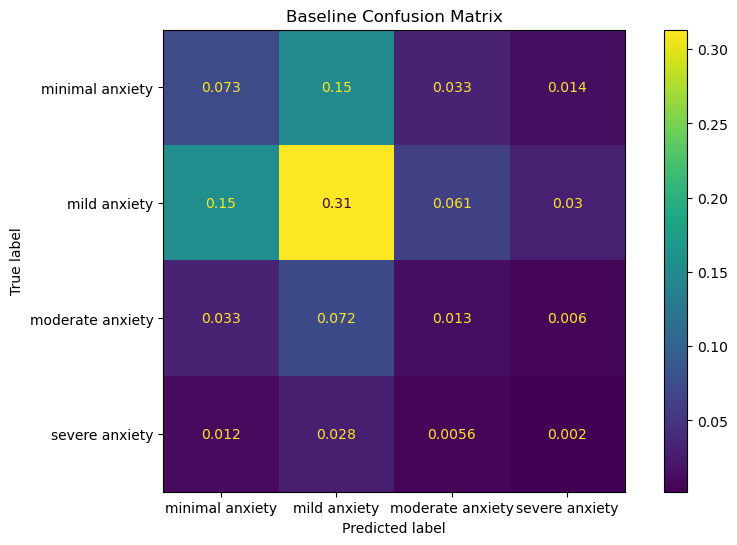

In [23]:
# confusion matrix for baseline DummyClassifier model 
fig,ax = plt.subplots(figsize=(10,6))
ax = ConfusionMatrixDisplay.from_predictions(y_test,base_y_pred, normalize='all',ax=ax)
plt.title("Baseline Confusion Matrix")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)
plt.savefig('images/baseline_correlation_matrix.png',dpi=300)

In [24]:
baseline_report = classification_report(y_test,base_y_pred,target_names=target_labels)
print(baseline_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015



### Baseline Model Conclusions 

**Conclusion**: 
Our baseline `DummyClassifier()` model has several key classification metrics to use for evaluating future models such as:
- accuracy: 0.4
- weighted average precision: 0.4
- weighted average recall: 0.4
- weighted average f1-score: 0.4

## Model I | Logistic Regression

We will first use `LogisticRegression()` and compare the baseline `LogisticRegression()` model with the baseline `DummyClassifier()` model. 

In [26]:
# feature selection of predictor variables
non_predict_cols = ['anxiety','GAD_T']

In [27]:
# defining our predictor and target variables 
X_1 = gamers_df.drop(columns=non_predict_cols)
y_1 = gamers_df['anxiety']

In [28]:
# label encoding our target variable 
y_1 = lab_enc.fit_transform(y_1)

In [29]:
# splitting dataset into train and test sets 
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.25,random_state=42)

In [30]:
# logistic regression pipeline with all features standardized 
log_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model', LogisticRegression(random_state=42,max_iter=10000))])
log_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [31]:
log_pipe.fit(X1_train, y1_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [32]:
log_y_pred = log_pipe.predict(X1_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


([<matplotlib.axis.YTick at 0x16f4709e400>,
 [Text(0, 0, 'minimal anxiety'),
  Text(0, 1, 'mild anxiety'),
  Text(0, 2, 'moderate anxiety'),
  Text(0, 3, 'severe anxiety')])

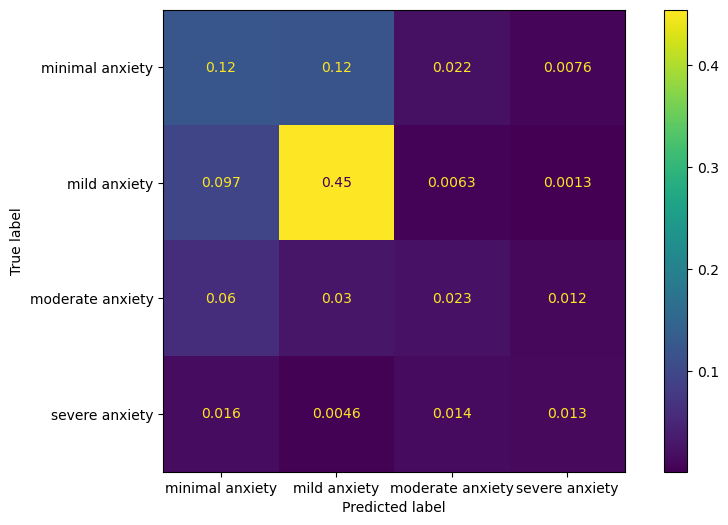

In [37]:
# confusion matrix for baseline LogisticRegression model 
fig,ax = plt.subplots(figsize=(10,6))
ax=ConfusionMatrixDisplay.from_predictions(y1_test,log_y_pred, normalize='all',ax=ax)
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)

In [38]:
# classification report for base logistic regression model w.o hyperparamter tuning 
base_logreg_report = classification_report(y1_test,log_y_pred, target_names=target_labels)
print(base_logreg_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.45      0.43       817
    mild anxiety       0.75      0.81      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.38      0.27      0.31       142

        accuracy                           0.61      3015
       macro avg       0.47      0.43      0.44      3015
    weighted avg       0.59      0.61      0.60      3015



In [39]:
# accuracy score for our base logistic regression model w.o hyperparameter tuning 
# base logistic regression uses all features 
accuracy_score(y1_test, log_y_pred)

0.6119402985074627

### Logistic Regression Hyperparameter Tuning 

In [40]:
# hyperparameter grid for Logistic Regression
baselog_pipe_grid = {'model__penalty':['l2'],
                 'model__C': [1e-4,1e-3,1e-2,1e-1,1],
                'model__solver':['lbfgs','newton-cg'],
                'model__class_weight':[None,'balanced']}

In [41]:
# RSV pipeline using hyperparameter grid
log_rsv_pipe = RandomizedSearchCV(estimator = log_pipe, 
                                       param_distributions = baselog_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [42]:
# fitting on training data 
log_rsv_pipe.fit(X1_train,y1_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1],
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__penalty': ['l2'],
                                        'model__solver': ['lbfgs',
                                                          'newton-cg']})

In [43]:
# accuracy score
log_rsv_pipe.best_score_

0.6087597288875191

In [44]:
log_rsv_pipe.best_params_

{'model__solver': 'lbfgs',
 'model__penalty': 'l2',
 'model__class_weight': None,
 'model__C': 0.01}

In [45]:
# predicting on test set using best params 
log_best_model = log_rsv_pipe.best_estimator_
best_log_ypred = log_best_model.predict(X1_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


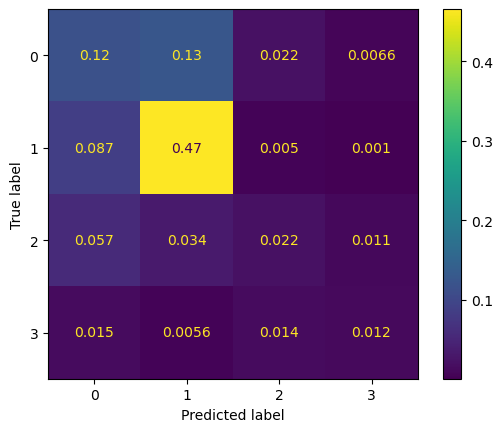

In [46]:
ConfusionMatrixDisplay.from_predictions(y1_test,best_log_ypred,normalize='all')

In [47]:
best_log_reg_report=classification_report(y1_test,best_log_ypred, target_names=target_labels)
print(best_log_reg_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.43      0.43       817
    mild anxiety       0.74      0.83      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.39      0.26      0.31       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.59      0.62      0.60      3015



### Baseline Logistic Regression Model & SMOTE 

To address the class imbalance found in EDA, we will use SMOTE to evaluate whether our baseline logistic regression model's performance improves. 

In [48]:
# feature selection 
X_1_sm = gamers_df.drop(columns=non_predict_cols)
y_1_sm = gamers_df['anxiety']

In [49]:
# label encoding our target variable 
y_1_sm = lab_enc.fit_transform(y_1_sm)

In [53]:
# train-test splitting data  
X1_sm_train, X1_sm_test, y1_sm_train, y1_sm_test = train_test_split(X_1_sm, y_1_sm, test_size = 0.25,random_state=42)

In [58]:
# creating a new pipeline that uses SMOTE 
sm_log_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model',LogisticRegression(random_state=42,max_iter=10000))])
sm_log_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [62]:
sm_log_pipe.fit(X1_sm_train,y1_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [63]:
# predictions using baseline LogisticRegression model + SMOTE 
sm_log_preds = sm_log_pipe.predict(X1_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [64]:
# classification report of base Logistic Regression model using SMOTE 
log_reg_sm_report = classification_report(y1_sm_test,sm_log_preds,target_names=target_labels)
print(log_reg_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.39      0.34      0.36       817
    mild anxiety       0.81      0.72      0.76      1683
moderate anxiety       0.20      0.27      0.23       373
  severe anxiety       0.23      0.51      0.32       142

        accuracy                           0.55      3015
       macro avg       0.41      0.46      0.42      3015
    weighted avg       0.59      0.55      0.57      3015



## Logistic Regression Model Evaluation 

In [69]:
print(f"Logistic Regression with All Features Classification Report")
print(base_logreg_report)
print('====================================================================')
print(f"Logistic Regression with All Features & SMOTE Classification Report")
print(log_reg_sm_report)
print('====================================================================================')
print(f"Logistic Regression with All Features & Hyperparameter Tuning Classification Report")
print(best_log_reg_report)

Logistic Regression with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.45      0.43       817
    mild anxiety       0.75      0.81      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.38      0.27      0.31       142

        accuracy                           0.61      3015
       macro avg       0.47      0.43      0.44      3015
    weighted avg       0.59      0.61      0.60      3015

Logistic Regression with All Features & SMOTE Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.39      0.34      0.36       817
    mild anxiety       0.81      0.72      0.76      1683
moderate anxiety       0.20      0.27      0.23       373
  severe anxiety       0.23      0.51      0.32       142

        accuracy                           0.55      3015
       macro avg       0.41      0.46      0.42      30

### Model Evaluation Conclusions

**Questions:** 
- What conclusions can we draw based on hyperparameter tuning?
- What is our best model given different scoring criterions?

**Best Logistic Regression Model**
- Logistic Regression with Hyperparameter Tuning

## Model II | Decision Trees 

In [70]:
# separating our target and predictor variables 
X_2 = gamers_df.drop(columns=non_predict_cols)
y_2 = gamers_df['anxiety']

In [71]:
# label encoding our target variable 
y_2 = lab_enc.fit_transform(y_2)

In [72]:
# splitting our data into training and test set 
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.25,random_state=42)

In [73]:
# DecisionTree pipeline with all features standardized 
dt_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      DecisionTreeClassifier(random_state=42))])
dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [75]:
# fitting DecisionTree Classifier on training set 
dt_pipe.fit(X2_train,y2_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [76]:
# predictions using Decision Tree Classifier 
dt_y_pred = dt_pipe.predict(X2_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


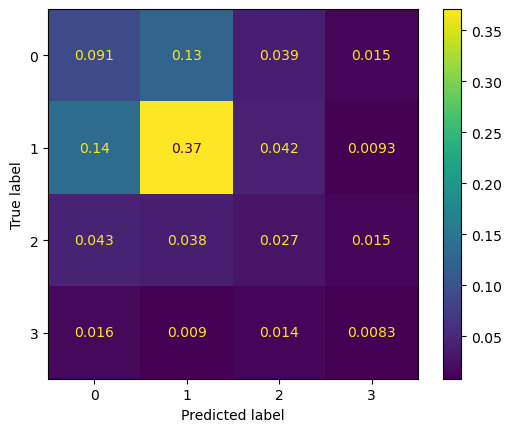

In [77]:
ConfusionMatrixDisplay.from_predictions(y2_test,dt_y_pred, normalize='all')

In [78]:
base_dt_report = classification_report(y2_test,dt_y_pred, target_names=target_labels)
print(base_dt_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.32      0.33      0.33       817
    mild anxiety       0.68      0.66      0.67      1683
moderate anxiety       0.22      0.22      0.22       373
  severe anxiety       0.17      0.18      0.18       142

        accuracy                           0.50      3015
       macro avg       0.35      0.35      0.35      3015
    weighted avg       0.50      0.50      0.50      3015



### Baseline Decision Tree Model & SMOTE 

In [79]:
# feature selection 
X_2_sm = gamers_df.drop(columns=non_predict_cols)
y_2_sm = gamers_df['anxiety']

In [80]:
# label encoding our target variable 
y_2_sm = lab_enc.fit_transform(y_2_sm)

In [82]:
# train-test splitting data 
X2_sm_train, X2_sm_test, y2_sm_train, y2_sm_test = train_test_split(X_2_sm, y_2_sm, test_size = 0.25,random_state=42)

In [85]:
# new pipeline for DecisionTreeClassifier + SMOTE
sm_dt_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model',LogisticRegression(random_state=42,max_iter=10000))])
sm_dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [87]:
# fitting new Pipeline onto training data
sm_dt_pipe.fit(X2_sm_train,y2_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [88]:
# predictions using baseline Decision Tree model + SMOTE 
sm_dt_preds = sm_dt_pipe.predict(X2_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [89]:
# classification report of base Decision Tree Classifier using SMOTE 
dt_sm_report = classification_report(y2_sm_test,sm_dt_preds)
print(dt_sm_report)

              precision    recall  f1-score   support

           0       0.39      0.34      0.36       817
           1       0.81      0.72      0.76      1683
           2       0.20      0.27      0.23       373
           3       0.23      0.51      0.32       142

    accuracy                           0.55      3015
   macro avg       0.41      0.46      0.42      3015
weighted avg       0.59      0.55      0.57      3015



### Hyperparameter Tuning Baseline Decision Tree Classifier

In [98]:
# DecisionTreeClassifier parameters grid 
dt_params_grid = {'model__max_depth':[2,4,6,8,10],
                 'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [99]:
# using RandomSearchCV with grid parameters,
dt_random_cv = RandomizedSearchCV(estimator = dt_pipe, 
                                       param_distributions = dt_params_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [100]:
dt_random_cv.fit(X2_train,y2_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                                              sparse_output=False)),
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [2, 4, 6, 8, 10],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000]})

In [93]:
# accuracy score of best Decision Tree Model with best params 
dt_random_cv.best_score_, dt_random_cv.best_params_

(0.6205920373550147,
 {'model__min_samples_split': 10,
  'model__min_samples_leaf': 100,
  'model__max_depth': 4})

In [106]:
# creating new variable to house hyperparameter tuned DecisionTreeClassifier 
best_dt_preds = dt_random_cv.predict(X2_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
# classification report using the most accurate DecisionTreeClassifier model 
best_dt_report = classification_report(y2_test,best_dt_preds,target_names=target_labels)
print(best_dt_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.60      0.50       817
    mild anxiety       0.81      0.74      0.78      1683
moderate anxiety       0.37      0.24      0.29       373
  severe anxiety       0.39      0.23      0.29       142

        accuracy                           0.62      3015
       macro avg       0.50      0.45      0.46      3015
    weighted avg       0.63      0.62      0.62      3015



## Model Evaluation 

In [108]:
print(f"Decision Tree with All Features Classification Report")
print(base_dt_report)
print('====================================================================')
print(f"Decision Tree with All Features & SMOTE Classification Report")
print(dt_sm_report)
print('====================================================================')
print(f"Decision Tree with All Features & Hyperparameter Tuning Classification Report")
print(best_dt_report)

Decision Tree with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.32      0.33      0.33       817
    mild anxiety       0.68      0.66      0.67      1683
moderate anxiety       0.22      0.22      0.22       373
  severe anxiety       0.17      0.18      0.18       142

        accuracy                           0.50      3015
       macro avg       0.35      0.35      0.35      3015
    weighted avg       0.50      0.50      0.50      3015

Decision Tree with All Features & SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.39      0.34      0.36       817
           1       0.81      0.72      0.76      1683
           2       0.20      0.27      0.23       373
           3       0.23      0.51      0.32       142

    accuracy                           0.55      3015
   macro avg       0.41      0.46      0.42      3015
weighted avg       0.59      0.55    

### Model Evaluation Conclusions

**Questions:** 
- What conclusions can we draw based on hyperparameter tuning?
- What is our best model given different scoring criterions?

**Best Decision Tree Model**
- Decision Tree with All Features & Hyperparameter Tuned 

## Model III | Random Forest 

In [109]:
# separating our target and predictor variables 
X_3 = gamers_df.drop(columns=non_predict_cols)
y_3 = gamers_df['anxiety']

In [110]:
# label encoding our target variable 
y_3 = lab_enc.fit_transform(y_3)

In [111]:
# splitting our data into training and test set 
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3, y_3, test_size = 0.25,random_state=42)

In [112]:
# RandomForest pipeline with all features standardized 
rf_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      RandomForestClassifier(random_state=42))])
rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [113]:
rf_pipe.fit(X3_train, y3_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [114]:
rf_y_pred = rf_pipe.predict(X3_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


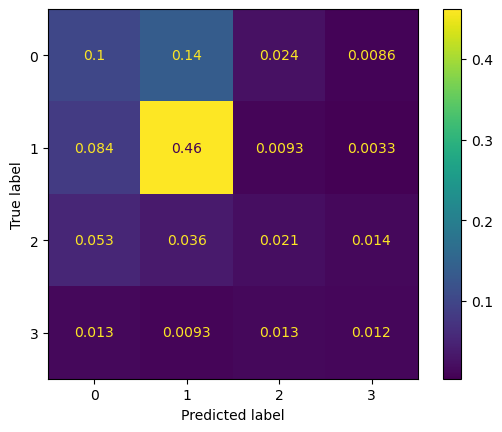

In [115]:
ConfusionMatrixDisplay.from_predictions(y3_test, rf_y_pred, normalize='all')

In [116]:
base_rf_report = classification_report(y3_test, rf_y_pred, target_names = target_labels)
print(base_rf_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.37      0.39       817
    mild anxiety       0.72      0.83      0.77      1683
moderate anxiety       0.31      0.17      0.22       373
  severe anxiety       0.32      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.56      0.60      0.57      3015



### Baseline Random Forest Model & SMOTE 

In [156]:
# feature selection 
X_3_sm = gamers_df.drop(columns=non_predict_cols)
y_3_sm = gamers_df['anxiety']

In [157]:
# label encoding our target variable 
y_3_sm = lab_enc.fit_transform(y_3_sm)

In [158]:
# splitting dataset into train-test data 
X3_sm_train, X3_sm_test, y3_sm_train, y3_sm_test = train_test_split(X_3_sm, y_3_sm, test_size = 0.25,random_state=42)

In [159]:
# creating new Pipeline with SMOTE
sm_rf_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote', SMOTE(random_state=42)),
                        ('model', RandomForestClassifier(random_state=42))])

In [160]:
# fitting SMOTE pipeline onto training data 
sm_rf_pipe.fit(X3_sm_train,y3_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier(random_state=42))])

In [161]:
# predictions using baseline Random Forst model + SMOTE 
sm_rf_preds = sm_rf_pipe.predict(X3_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [162]:
# classification report of base RandomForestClassifier model using SMOTE 
rf_sm_report = classification_report(y3_sm_test,sm_rf_preds, target_names=target_labels)
print(rf_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.40      0.40       817
    mild anxiety       0.74      0.79      0.76      1683
moderate anxiety       0.29      0.19      0.23       373
  severe anxiety       0.30      0.32      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weighted avg       0.57      0.59      0.58      3015



### Hyperparameter Tuning Baseline Random Forest Classifier

In [124]:
# RandomForestClassifier parameters grid 
rf_pipe_grid = {'model__n_estimators':[50,100,150,200,250],
                'model__max_features':['sqrt','log2'],
                'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [125]:
# using RandomizedSearchCV with new grid parameters,
rf_random_cv = RandomizedSearchCV(estimator = rf_pipe, 
                                       param_distributions = rf_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [126]:
# fitting RandomizedSearchCV with training data 
rf_random_cv.fit(X3_train,y3_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000],
                                        'model__n_estimators': [50, 100, 150,
                                                                200, 250]})

In [135]:
# accuracy score and best params side-by-side 
print(f"training set accuracy: {rf_random_cv.best_score_}")
print(f"best params: {rf_random_cv.best_params_}")

training set accuracy: 0.6111917061692521
best params: {'model__n_estimators': 150, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt'}


In [136]:
# calculating predictions based on best parameters for accuracy 
best_rf_preds = rf_random_cv.predict(X3_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [137]:
best_rf_report = classification_report(y3_test, best_rf_preds, target_names = target_labels)
print(best_rf_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.39      0.40       817
    mild anxiety       0.72      0.84      0.78      1683
moderate anxiety       0.35      0.16      0.22       373
  severe anxiety       0.34      0.25      0.29       142

        accuracy                           0.61      3015
       macro avg       0.46      0.41      0.42      3015
    weighted avg       0.57      0.61      0.58      3015



## Model Evaluation 

In [163]:
print(f"Random Forest with All Features Classification Report")
print(base_rf_report)
print('====================================================================')
print(f"Random Forest with All Features & SMOTE Classification Report")
print(rf_sm_report)
print('====================================================================')
print(f"Random Forest with All Features & Hyperparameter Tuning Classification Report")
print(best_rf_report)

Random Forest with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.37      0.39       817
    mild anxiety       0.72      0.83      0.77      1683
moderate anxiety       0.31      0.17      0.22       373
  severe anxiety       0.32      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.56      0.60      0.57      3015

Random Forest with All Features & SMOTE Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.40      0.40       817
    mild anxiety       0.74      0.79      0.76      1683
moderate anxiety       0.29      0.19      0.23       373
  severe anxiety       0.30      0.32      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weigh

## Model IV | K-Nearest Neighbors Classification 

In [139]:
# separating our target and predictor variables 
X_5 = gamers_df.drop(columns=non_predict_cols)
y_5 = gamers_df['anxiety']

In [140]:
# label encoding our target variable 
y_5 = lab_enc.fit_transform(y_5)

In [141]:
# splitting our data into training and test set 
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.25,random_state=42)

In [143]:
# K-Nearest Neighbors Classification pipeline with all features standardized 
knn_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model',
      KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [144]:
# fitting KNN pipeline on training data
knn_pipe.fit(X5_train,y5_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [145]:
# predicting on test data
knn_y_pred = knn_pipe.predict(X5_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


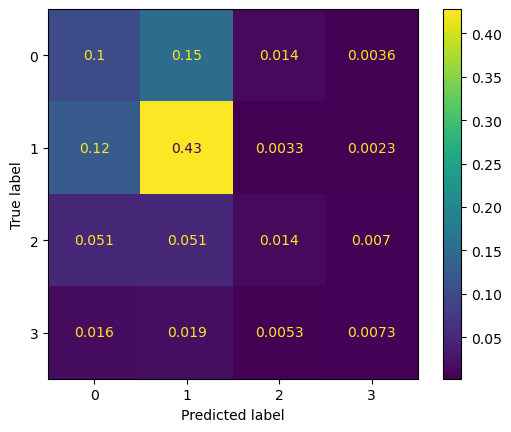

In [146]:
ConfusionMatrixDisplay.from_predictions(y5_test, knn_y_pred, normalize='all')

In [147]:
print(classification_report(y5_test, knn_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.34      0.37      0.36       817
    mild anxiety       0.66      0.77      0.71      1683
moderate anxiety       0.38      0.11      0.17       373
  severe anxiety       0.36      0.15      0.22       142

        accuracy                           0.55      3015
       macro avg       0.44      0.35      0.36      3015
    weighted avg       0.52      0.55      0.52      3015



### Baseline K-Nearest Neighbors & SMOTE 

In [176]:
# feature selection 
X_5_sm = gamers_df.drop(columns=non_predict_cols)
y_5_sm = gamers_df['anxiety']

In [177]:
# label encoding our target variable 
y_5_sm = lab_enc.fit_transform(y_5_sm)

In [178]:
# splitting dataset into train-test data 
X5_sm_train, X5_sm_test, y5_sm_train, y5_sm_test = train_test_split(X_5_sm, y_5_sm, test_size = 0.25,random_state=42)

In [179]:
# creating new Pipeline with SMOTE
sm_knn_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote', SMOTE(random_state=42)),
                        ('model', KNeighborsClassifier())])

In [180]:
# fitting SMOTE pipeline onto training data 
sm_knn_pipe.fit(X5_sm_train,y5_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                                                                   StandardScaler())]),
                                                  ['GADE', 'Work']),
                                                 ('ohe_pipeline',
                                                  Pipeline(steps=[('obj_norm',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('ohe_norm',
                                                                   StandardScaler())]),
                                                  ['Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', KNeighborsClassifier())])

In [181]:
# predictions using baseline Decision Tree model + SMOTE 
sm_knn_preds = sm_knn_pipe.predict(X5_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [182]:
# classification report of base Logistic Regression model using SMOTE 
knn_sm_report = classification_report(y5_sm_test,sm_knn_preds, target_names=target_labels)
print(knn_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.31      0.38      0.34       817
    mild anxiety       0.72      0.53      0.61      1683
moderate anxiety       0.20      0.27      0.23       373
  severe anxiety       0.18      0.33      0.23       142

        accuracy                           0.45      3015
       macro avg       0.35      0.38      0.36      3015
    weighted avg       0.52      0.45      0.48      3015



### Model Evaluation 

### K-Nearest Neighbors Hyperparameter Tuning 

In [183]:
# KNearestNeighbors parameters grid 
knn_pipe_grid = {'model__n_neighbors':[3, 11, 15],
                 'model__p': [1, 2]}

In [184]:
# using RandomizedSearchCV with new grid parameters,
knn_random_cv = RandomizedSearchCV(estimator = knn_pipe, 
                                       param_distributions = knn_pipe_grid,
                                       n_iter = 6, 
                                       cv = 5)

In [185]:
knn_random_cv.fit(X5_train,y5_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                                              ('ohe_pipeline',
                                                                               Pipeline(steps=[('obj_norm',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('ohe_norm',
                                                                                                StandardScaler())]),
                                                                               ['Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=6,
                   param_distributions={'model__n_neighbors': [3, 11, 15],
                                        'model__p': [1, 2]})

In [186]:
# calculating predictions based on best parameters for accuracy 
best_knn_preds = knn_random_cv.predict(X5_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [187]:
print(classification_report(y5_test, best_knn_preds, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.38      0.27      0.31       817
    mild anxiety       0.63      0.88      0.73      1683
moderate anxiety       0.33      0.06      0.10       373
  severe anxiety       0.70      0.13      0.22       142

        accuracy                           0.58      3015
       macro avg       0.51      0.33      0.34      3015
    weighted avg       0.53      0.58      0.52      3015



### Conclusion

**Thoughts**

## Model VI | XG Boost

In [188]:
# separating our target and predictor variables 
X_6 = gamers_df.drop(columns=non_predict_cols)
y_6 = gamers_df['anxiety']

In [189]:
# label encoding our target variable 
y_6 = lab_enc.fit_transform(y_6)

In [190]:
# splitting our data into training and test set 
X6_train, X6_test, y6_train, y6_test = train_test_split(X_6, y_6, test_size = 0.25,random_state=42)

In [191]:
# XGBoost pipeline with all features standardized 
xgb_pipe = Pipeline([('preprocess', model_preprocess_ct),
     ('model', XGBClassifier(random_state=42))])
xgb_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [192]:
# fitting XGB pipeline on training set 
xgb_pipe.fit(X6_train,y6_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [193]:
# baseline prediction for XGBoostClassification on test set 
xgb_pipe_preds = xgb_pipe.predict(X6_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


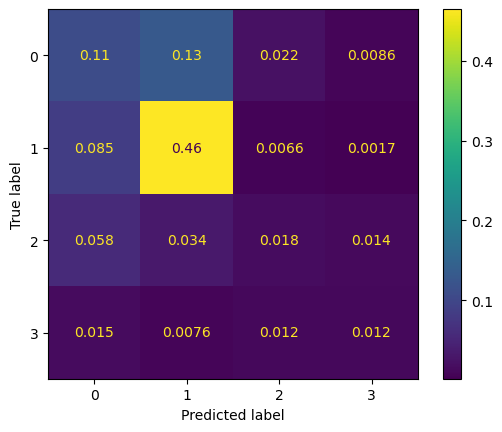

In [194]:
ConfusionMatrixDisplay.from_predictions(y6_test,xgb_pipe_preds, normalize='all')

In [195]:
base_xgb_report = classification_report(y6_test,xgb_pipe_preds, target_names=target_labels)
print(base_xgb_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.40      0.40       817
    mild anxiety       0.73      0.83      0.78      1683
moderate anxiety       0.30      0.14      0.20       373
  severe anxiety       0.34      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.57      0.60      0.58      3015



### Baseline XGBoost Model & SMOTE 

In [196]:
# feature selection 
X_6_sm = gamers_df.drop(columns=non_predict_cols)
y_6_sm = gamers_df['anxiety']

In [197]:
# label encoding our target variable 
y_6_sm = lab_enc.fit_transform(y_6_sm)

In [198]:
X6_sm_train, X6_sm_test, y6_sm_train, y6_sm_test = train_test_split(X_6_sm, y_6_sm, test_size = 0.25,random_state=42)

In [201]:
sm_xgb_pipe = Pipeline([('preprocess', model_preprocess_ct),
                        ('smote',SMOTE(random_state=42)),
                        ('model', XGBClassifier(random_state=42))])

In [202]:
sm_xgb_pipe.fit(X6_sm_train,y6_sm_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42)),
                                                                  ('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Hours', 'streams']),
                                                 ('obj_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant')),
                                                                  ('ohe_tran...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [203]:
# predictions using baseline Decision Tree model + SMOTE 
sm_xgb_preds = sm_xgb_pipe.predict(X6_sm_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [204]:
# classification report of base XGBoost model using SMOTE 
xgb_sm_report = classification_report(y6_sm_test,sm_xgb_preds, target_names=target_labels)
print(xgb_sm_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.37      0.39       817
    mild anxiety       0.74      0.81      0.77      1683
moderate anxiety       0.28      0.19      0.23       373
  severe anxiety       0.30      0.33      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weighted avg       0.57      0.59      0.58      3015



## XGBoost Hyperparameter Tuning

In [205]:
xgb_params = {'model__max_depth': [3,4, 5], 
              'model__learning_rate': [.1, .3, .5],
              'model__gamma': [0,5,10], 
              'model__n_estimators': [50,100, 150] }

In [206]:
# using RandomizedSearchCV with new grid parameters,
xgb_random_cv = RandomizedSearchCV(estimator = xgb_pipe, 
                                       param_distributions = xgb_params,
                                       n_iter = 10, 
                                       cv = 5)

In [207]:
xgb_random_cv.fit(X6_train,y6_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.war

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42)),
                                                                                               ('agenorm',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Hours',
                                                                                'streams']),
                                                                              ('obj_pipeline',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Did '
                                                                                                                         'not '
                                                                                                                         'answer...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            objective='multi:softprob',
                                                            predictor=None, ...))]),
                   param_distributions={'model__gamma': [0, 5, 10],
                                        'model__learning_rate': [0.1, 0.3, 0.5],
                                        'model__max_depth': [3, 4, 5],
                                        'model__n_estimators': [50, 100, 150]})

In [208]:
# training set accuracy using XGBoost
xgb_random_cv.best_score_

0.6212555707206348

In [209]:
# predictions on test set 
best_xgb_preds = xgb_random_cv.predict(X6_test)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


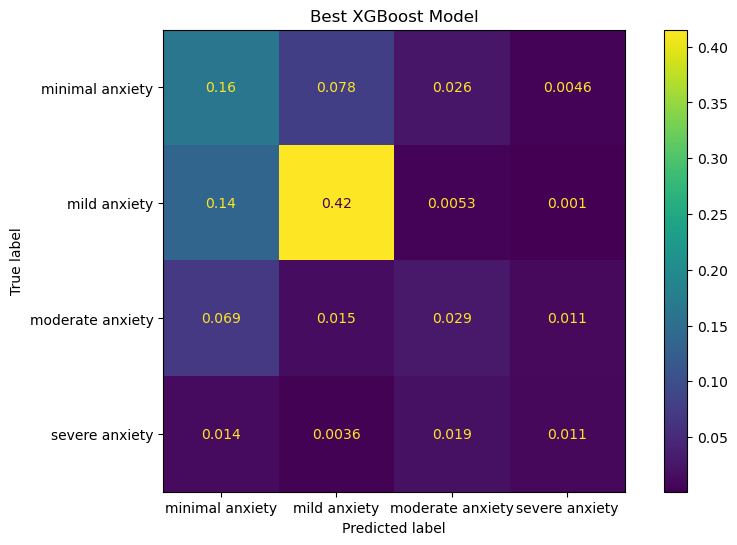

In [210]:
# confusion matrix for best XGBoost model 
fig,ax = plt.subplots(figsize=(10,6))
ax = ConfusionMatrixDisplay.from_predictions(y6_test,best_xgb_preds, normalize='all',ax=ax)
plt.title("Best XGBoost Model")
plt.xticks(ticks=[0,1,2,3], labels=target_labels)
plt.yticks(ticks=[0,1,2,3], labels=target_labels)
plt.savefig('images/bestxgbmodel_correlation_matrix.png',dpi=300)

In [211]:
best_xgb_report = classification_report(y6_test,best_xgb_preds, target_names=target_labels)
print(best_xgb_report)

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.60      0.50       817
    mild anxiety       0.81      0.74      0.78      1683
moderate anxiety       0.37      0.24      0.29       373
  severe anxiety       0.39      0.23      0.29       142

        accuracy                           0.62      3015
       macro avg       0.50      0.45      0.46      3015
    weighted avg       0.63      0.62      0.62      3015



## Model Evaluation 

In [212]:
print(f"XGBoost Model with All Features Classification Report")
print(base_xgb_report)
print('====================================================================')
print(f"XGBoost Model with All Features & SMOTE Classification Report")
print(xgb_sm_report)
print('====================================================================')
print(f"XGBoost Model with All Features & Hyperparameter Tuning Classification Report")
print(best_xgb_report)

XGBoost Model with All Features Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.40      0.40       817
    mild anxiety       0.73      0.83      0.78      1683
moderate anxiety       0.30      0.14      0.20       373
  severe anxiety       0.34      0.26      0.29       142

        accuracy                           0.60      3015
       macro avg       0.44      0.41      0.42      3015
    weighted avg       0.57      0.60      0.58      3015

XGBoost Model with All Features & SMOTE Classification Report
                  precision    recall  f1-score   support

 minimal anxiety       0.41      0.37      0.39       817
    mild anxiety       0.74      0.81      0.77      1683
moderate anxiety       0.28      0.19      0.23       373
  severe anxiety       0.30      0.33      0.31       142

        accuracy                           0.59      3015
       macro avg       0.43      0.43      0.43      3015
    weigh

# Conclusion 

In [214]:
print(f"Baseline Dummy Classifier")
print(baseline_report)
print('====================================================================')
print(f"Best Logistic Regression Model")
print(best_log_reg_report)
print('====================================================================')
print(f"Best Decision Tree Regression Model ")
print(best_dt_report)
print('====================================================================')
print(f"Best Random Forest Tree Regression Model")
print(best_rf_report)
print('====================================================================')
print(f"Best XGBoost Regression Model")
print(best_xgb_report)

Baseline Dummy Classifier
                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015

Best Logistic Regression Model
                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.43      0.43       817
    mild anxiety       0.74      0.83      0.78      1683
moderate anxiety       0.35      0.18      0.24       373
  severe anxiety       0.39      0.26      0.31       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.59      0.62      0.60      3015

Best Deci

## XGBoost Feature Importances

In [783]:
names = xgb_random_cv.best_estimator_.steps[0][1].get_feature_names_out()

In [785]:
feature_importances = xgb_random_cv.best_estimator_.named_steps['model'].feature_importances_

In [860]:
best_features = list(zip(names,feature_importances))
best_features_df = pd.DataFrame(best_features, columns=['Name', 'Feature Importance'])
best_features_df['Feature Importance'] = best_features_df['Feature Importance'] * 100

In [861]:
best_features_df = best_features_df[best_features_df['Feature Importance'] != 0]

In [862]:
best_features_df

,Name,Feature Importance
1,num_pipeline__Hours,2.896765
3,obj_pipeline__GADE_Extremely difficult,22.430065
4,obj_pipeline__GADE_Not difficult at all,29.818020
5,obj_pipeline__GADE_Somewhat difficult,20.675262
6,obj_pipeline__GADE_Very difficult,13.973306
28,ohe_pipeline__whyplay_winning,3.559901
29,ohe_pipeline__Gender_Male,3.251722
124,ohe_pipeline__Birthplace_Romania,3.394956


In [863]:
bar_order = best_features_df.sort_values('Feature Importance',ascending = False)['Name']

In [851]:
feature_tick_labels = ['GADE_Not diffficult at all','GADE_Extremely difficult','GADE_Somewhat Difficult',
                       'GADE_Very Difficult','Winning','Born in Romania','Male', 'Hours Played']

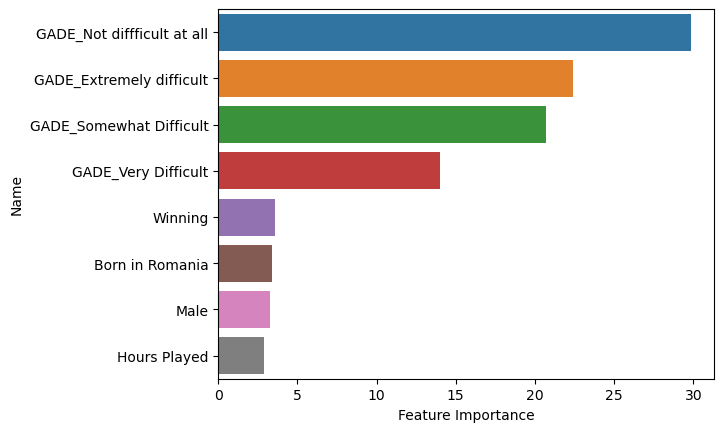

In [1135]:
ax = sns.barplot(y='Name',x='Feature Importance',data=best_features_df,order=bar_order)
ax.set_yticklabels(feature_tick_labels)
plt.savefig('images/feature_importances.png',dpi=600)

## Classification Metrics for Best Models 

### Baseline Model: `DummyClassifier()`

In [1083]:
# exporting baseline classification report to a dictionary 
baseline_report_dict = classification_report(y_test,base_y_pred,target_names=target_labels,output_dict=True)

In [1084]:
# creating new dataframe with classification metrics 
metrics_df = pd.DataFrame(columns=['model_name','accuracy','precision','recall','f1-score','support'])

In [1085]:
baseline_dict = baseline_report_dict['weighted avg']
baseline_dict.update({'model_name':'baseline'})
baseline_dict.update({'accuracy':baseline_report_dict['accuracy']})
baseline_dict

{'precision': 0.39830827664666074,
 'recall': 0.40066334991708125,
 'f1-score': 0.3994461198498057,
 'support': 3015,
 'model_name': 'baseline',
 'accuracy': 0.40066334991708125}

In [1086]:
metrics_df = metrics_df.append(baseline_dict,ignore_index=True)
metrics_df

C:\Users\Kevin\AppData\Local\Temp\ipykernel_32676\521539491.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015


### Hyperparameter Tuned Model: `LogisticRegression()`

In [1087]:
# exporting classification report as dictionary 
best_logreg_dict = classification_report(y1_test,best_log_ypred, target_names=target_labels,output_dict=True)

In [1088]:
best_logreg = best_logreg_dict['weighted avg']
best_logreg.update({'model_name':'tuned logreg'})
best_logreg.update({'accuracy':best_logreg_dict['accuracy']})
best_logreg

{'precision': 0.5891323607938105,
 'recall': 0.6169154228855721,
 'f1-score': 0.597188716148147,
 'support': 3015,
 'model_name': 'tuned logreg',
 'accuracy': 0.6169154228855721}

In [1089]:
metrics_df = metrics_df.append(best_logreg,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_32676\4276980871.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [1090]:
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015


### Hyperparameter Tuned Model: `DecisionTreeClassifier()`

In [1091]:
# exporting classification report as dictionary 
best_dt_dict = classification_report(y2_test,best_dt_preds,target_names=target_labels,output_dict=True)

In [1092]:
best_dt = best_dt_dict['weighted avg']
best_dt.update({'model_name':'tuned decision tree'})
best_dt.update({'accuracy':best_dt_dict['accuracy']})
best_dt

{'precision': 0.6335396847456916,
 'recall': 0.6182421227197347,
 'f1-score': 0.6180592765164579,
 'support': 3015,
 'model_name': 'tuned decision tree',
 'accuracy': 0.6182421227197347}

In [1093]:
metrics_df = metrics_df.append(best_dt,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_32676\2703978340.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [1094]:
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015
2,tuned decision tree,0.618242,0.633540,0.618242,0.618059,3015


### Hyperparameter Tuned Model: `XGBoostClassifier()`

In [1095]:
# exporting classification report as dictionary 
best_xgb_dict = classification_report(y6_test,best_xgb_preds, target_names=target_labels,output_dict=True)

In [1096]:
xgb_acc = best_xgb_dict['accuracy']

In [1097]:
best_xgb = best_xgb_dict['weighted avg']
best_xgb.update({'model_name':'tuned xgboost'})
best_xgb.update({'accuracy':best_xgb_dict['accuracy']})
best_xgb

{'precision': 0.6328486430090192,
 'recall': 0.6179104477611941,
 'f1-score': 0.6176580963803061,
 'support': 3015,
 'model_name': 'tuned xgboost',
 'accuracy': 0.6179104477611941}

In [1099]:
metrics_df = metrics_df.append(best_xgb,ignore_index=True)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_32676\4131615785.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [1100]:
metrics_df

,model_name,accuracy,precision,recall,f1-score,support
0,baseline,0.400663,0.398308,0.400663,0.399446,3015
1,tuned logreg,0.616915,0.589132,0.616915,0.597189,3015
2,tuned decision tree,0.618242,0.633540,0.618242,0.618059,3015
3,tuned xgboost,0.617910,0.632849,0.617910,0.617658,3015


In [ ]:
fig,ax = plt.subplots(4,1,figsize=(8,10))
sns.barplot(x='model_name',y='f1-score',data=metrics_df,ax=ax[0])
sns.barplot(x='model_name',y='recall',data=metrics_df,ax=ax[1])
sns.barplot(x='model_name',y='precision',data=metrics_df,ax=ax[2])
sns.barplot(x='model_name',y='accuracy',data=metrics_df,ax=ax[3])
ax[0].set_title("Classification Metrics per Model")
ax[3].set_xlabel("Model Name")
ax[0].set_ylabel("F1-Score")
ax[1].set_ylabel("Recall")
ax[2].set_ylabel("Precision")
ax[3].set_ylabel("Accuracy")
plt.savefig('images/model_classification_metrics.png',dpi=300)

## Conclusion 

# To Be Deleted?

In [603]:
# creating different preprocessing pipelines to dela with NaN values 
# pipeline to replace NaNs in 'GADE' and 'Work' columns with 'Did not answer'
gadsurvey_pipeline = Pipeline([('obj_imputer', SimpleImputer(strategy='most_frequent'))])

# pipeline to replace NaNs in 'Hours and 'streams' with median value 
game_habits_pipeline = Pipeline([('numimputer', IterativeImputer(initial_strategy='median',random_state=42))])

In [604]:
gadsurvey_pipeline

Pipeline(steps=[('obj_imputer', SimpleImputer(strategy='most_frequent'))])

In [605]:
game_habits_pipeline

Pipeline(steps=[('numimputer',
                 IterativeImputer(initial_strategy='median', random_state=42))])

In [19]:
# writing a ColumnTransformer object with our imputation pipelines 
preprocess_ct = ColumnTransformer(
    [("obj_imputer", gadsurvey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams'])])
preprocess_ct

NameError: name 'gadsurvey_pipeline' is not defined

In [145]:
dt_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
dt_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [146]:
# DecisionTree pipeline with all features standardized 
dt_pipe = Pipeline([('preprocess', dt_ct),
     ('model',
      DecisionTreeClassifier(random_state=42))])
dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

## Model IV | Naive Bayes

In [121]:
# separating our target and predictor variables 
X_4 = gamers_df.drop(columns=non_predict_cols)
y_4 = gamers_df['anxiety']

In [122]:
# label encoding our target variable 
y_4 = lab_enc.fit_transform(y_4)

In [123]:
# splitting our data into training and test set 
X4_train, X4_test, y4_train, y4_test = train_test_split(X_4, y_4, test_size = 0.25,random_state=42)

In [124]:
nb_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
nb_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [125]:
# Naive Bayes Classification pipeline with all features standardized 
nb_pipe = Pipeline([('preprocess', nb_ct),
     ('model',
      GaussianNB())])
nb_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', GaussianNB())])

In [126]:
nb_pipe.fit(X4_train,y4_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', GaussianNB())])

In [127]:
nb_y_pred = nb_pipe.predict(X4_test)

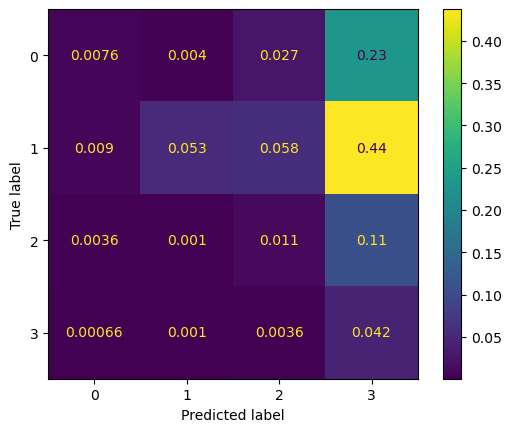

In [128]:
ConfusionMatrixDisplay.from_predictions(y4_test, nb_y_pred, normalize='all')

In [129]:
print(classification_report(y4_test, nb_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.37      0.03      0.05       817
    mild anxiety       0.90      0.10      0.17      1683
moderate anxiety       0.11      0.09      0.10       373
  severe anxiety       0.05      0.89      0.10       142

        accuracy                           0.11      3015
       macro avg       0.36      0.28      0.11      3015
    weighted avg       0.62      0.11      0.13      3015



#### Quadratic Discriminat Analysis (QDA)

In [331]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_pipe = Pipeline([('preprocess', nb_ct),
     ('model',
      QuadraticDiscriminantAnalysis())])
qda_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', QuadraticDiscriminantAnalysis())])

In [332]:
qda_pipe.fit(X4_train,y4_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', QuadraticDiscriminantAnalysis())])

In [334]:
qda_y_pred = qda_pipe.predict(X4_test)

In [335]:
print(classification_report(y4_test, qda_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.28      0.02      0.03       817
    mild anxiety       0.38      0.01      0.02      1683
moderate anxiety       0.11      0.08      0.09       373
  severe anxiety       0.05      0.91      0.09       142

        accuracy                           0.06      3015
       macro avg       0.20      0.25      0.06      3015
    weighted avg       0.30      0.06      0.03      3015



### Model Evaluation 